In [1]:
from eda_imports import *
import pysam
from sklearn import tree

In [2]:
df1 = pd.read_csv('../benchmark_transcriptome/after-num-suffix-reads-fix-renamed-header/benchmark.csv')
df1['program'] = 'karbor'

In [3]:
df_kleat2 = pd.read_csv('../kleat3_dev/preds_kleat2_whole_transcriptome.csv', sep='\t', header=None,
                 names=['sample_id', 'tree_max_depth', 'precision', 'recall', 'f1'])
df_kleat2['program'] = 'kleat2+DT'
df_kleat2.sample_id = df_kleat2.sample_id.replace({
    'UHRR-C1_S1_RNABloom': 'UHRC1',
    'UHRR-C2_S2_RNABloom': 'UHRC2',
    'Brain-C6_S4_RNABloom': 'HBRC6',
    'Brain-C4_S3_RNABloom': 'HBRC4',
})

learning curve

In [4]:
df_cat = pd.concat([df1, df_kleat2], sort=True)

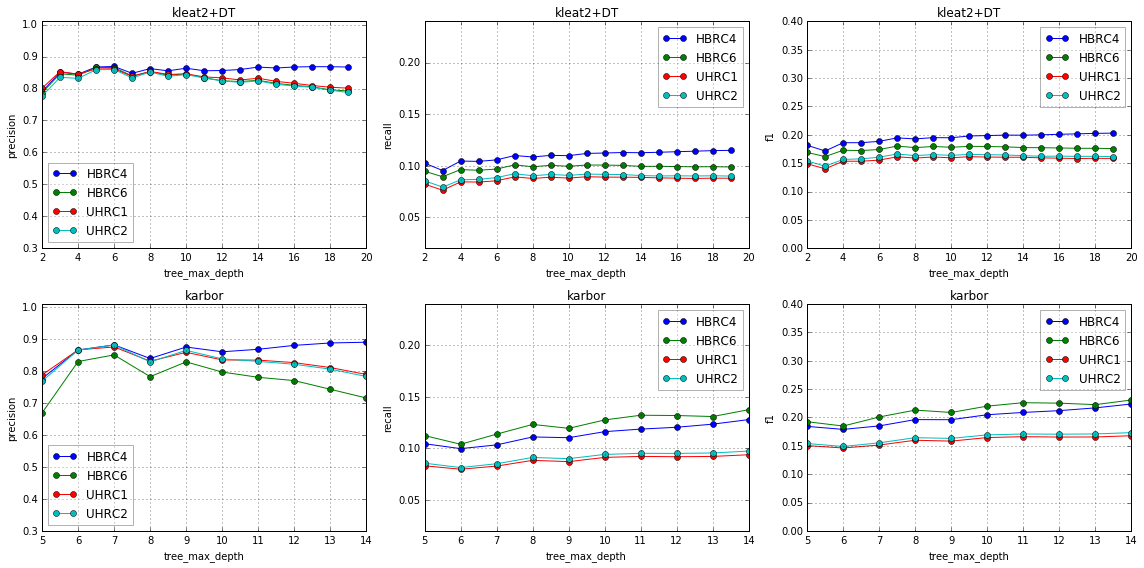

In [5]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8), 
#                          sharex=True, sharey=True
                        )
axes = axes.ravel()

for i, kleat_ver in enumerate(['kleat2+DT', 'karbor']):
    for j, met in enumerate(['precision', 'recall', 'f1']):
        ax = axes[i * 3 + j]
        for k, sample_id in enumerate(['HBRC4', 'HBRC6', 'UHRC1', 'UHRC2']):
            _df = df_cat.query(f'sample_id == "{sample_id}"')\
                .query(f'program == "{kleat_ver}"')\
                .sort_values('tree_max_depth')
            if _df.shape[0] > 1:
                _df.plot(x='tree_max_depth', y=met, marker='o', ax=ax, label=sample_id)
        ax.legend(loc='best', framealpha=0.3)
        ax.grid()
        ax.set_title(f'{kleat_ver}')
        ax.set_ylabel(met)

        # for 40 depth values
        if met == 'precision':
            ax.set_ylim(0.3, 1.01)
        elif met == 'recall':
            ax.set_ylim(0.02, 0.24)
        elif met == 'f1':
            ax.set_ylim(0, 0.4)
        
        # for 20 depth values
#         if met == 'precision':
#             ax.set_ylim(0.5, 0.98)
#         elif met == 'recall':
#             ax.set_ylim(0, 0.16)
#         elif met == 'f1':
#             ax.set_ylim(0, 0.3)
plt.tight_layout()

# max_depth=7

In [6]:
sys.path.insert(0, '../benchmark_scripts/')
from ml_utils import KARBOR_FEATURE_COLS

In [7]:
file = '../benchmark_transcriptome/after-num-suffix-reads-fix-renamed-header/benchmark.tree_max_depth_7.pkl'
tree_id = os.path.basename(file)
with open(file, 'rb') as inf:
    clf = pickle.load(inf)

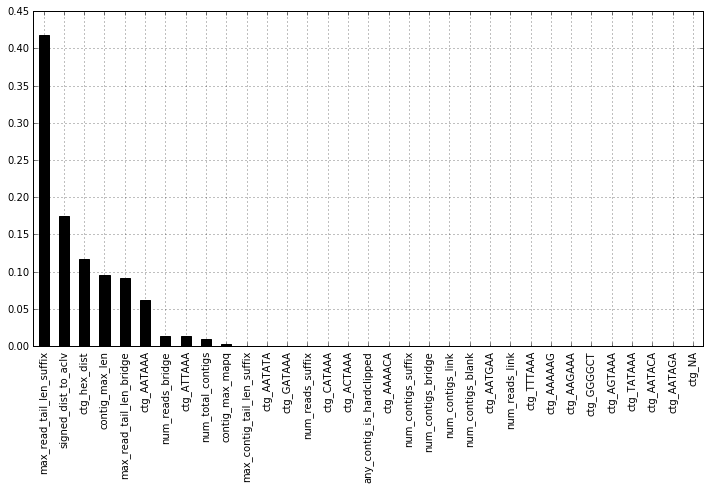

In [8]:
df_fea = pd.Series(clf.feature_importances_, index=KARBOR_FEATURE_COLS)

fig = plt.figure(figsize=(12, 6))
ax = df_fea.sort_values(ascending=False).plot.bar(color='black')
ax.grid()

# ax.set_yscale('log')

In [15]:
df_fea.sort_values(ascending=False).to_frame(name='importance').query('importance > 0').T

,max_suffix_contig_tail_len,signed_dist_to_aclv,max_contig_len,max_bridge_read_tail_len,ctg_hex_dist,ctg_AATAAA,ctg_ATTAAA,max_contig_mapq,num_blank_contigs,ctg_AAAAAG,num_bridge_contigs,ctg_TATAAA,num_total_contigs,num_suffix_contigs,ctg_AATATA,ctg_AATGAA,num_bridge_reads,ctg_ACTAAA,ctg_CATAAA,ctg_TTTAAA
importance,0.477568,0.190095,0.129829,0.085257,0.051394,0.042391,0.012641,0.003796,0.003541,0.001547,0.000526,0.000306,0.000291,0.000256,0.000219,0.000096,0.000091,0.000081,0.000048,0.000028


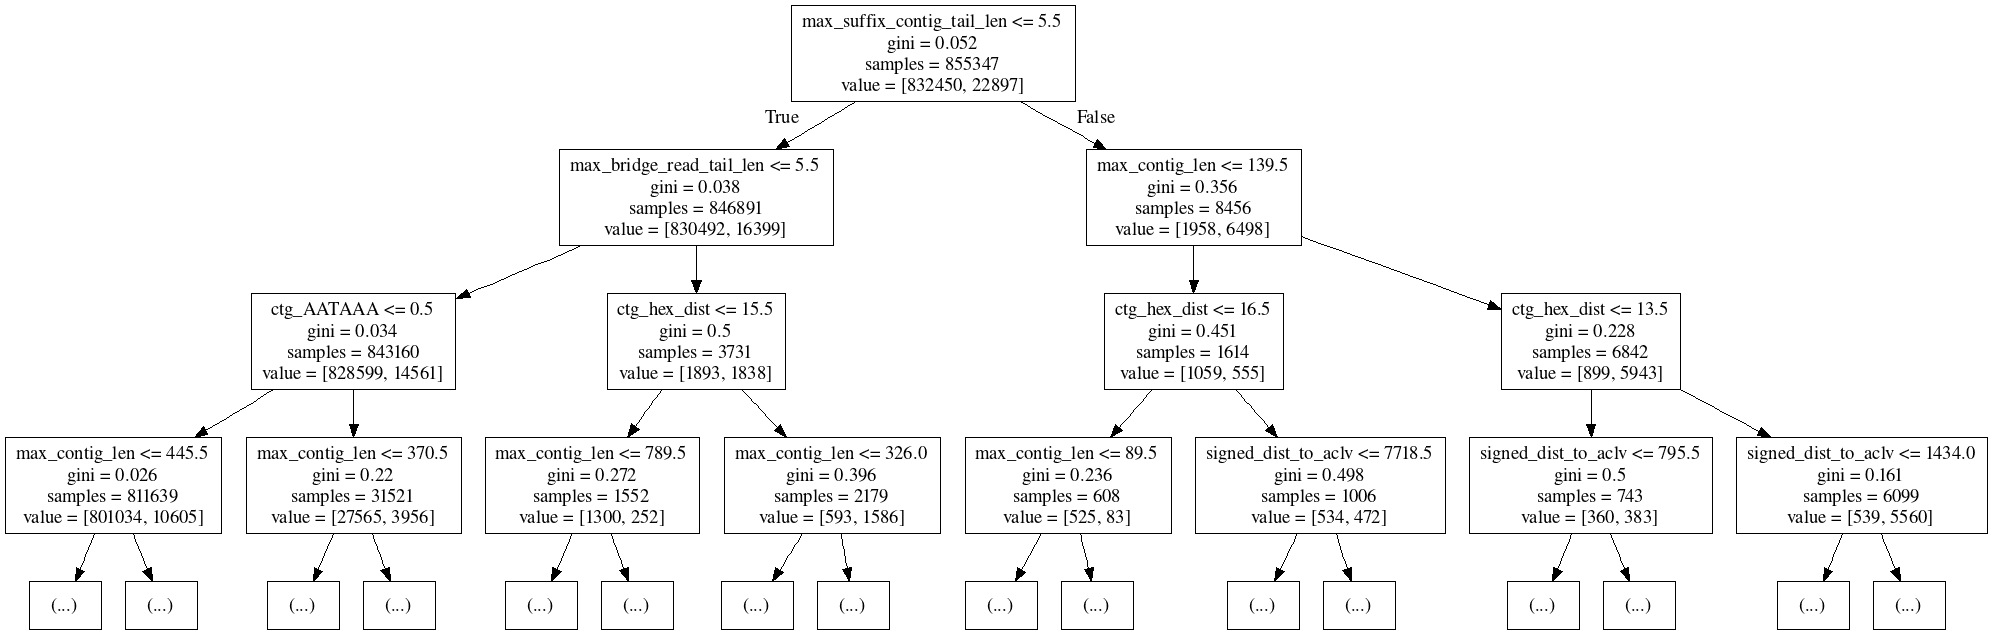

In [16]:
Image('../benchmark_transcriptome/benchmark.tree_max_depth_8.png')

In [34]:
from kleat.misc.settings import CANDIDATE_HEXAMERS

In [35]:
idx = [_ for _ in df_fea.sort_values(ascending=False).index.values if _.startswith('ctg') and _ != 'ctg_NA']
df_fea.loc[idx]

ctg_hex_dist    0.112516
ctg_AATAAA      0.050220
ctg_ATTAAA      0.010744
ctg_GATAAA      0.000265
ctg_AATATA      0.000202
ctg_TATAAA      0.000101
ctg_GGGGCT      0.000065
ctg_TTTAAA      0.000065
ctg_ACTAAA      0.000000
ctg_AATGAA      0.000000
ctg_AAGAAA      0.000000
ctg_AAAAAG      0.000000
ctg_AGTAAA      0.000000
ctg_CATAAA      0.000000
ctg_AATACA      0.000000
ctg_AATAGA      0.000000
ctg_AAAACA      0.000000
dtype: float64

In [36]:
df_strength = pd.Series(df_fea.loc[idx].index.values).to_frame(name='hexamer')
df_strength['hexamer'] = df_strength['hexamer'].str.replace('ctg_', '')

In [37]:
df_strength['learned'] = df_strength.shape[0] - (df_strength.index.values)

In [38]:
df_strength_literature = pd.DataFrame(CANDIDATE_HEXAMERS, columns=['hexamer', 'literature'])

In [39]:
df_strength_merged = df_strength.merge(df_strength_literature, on='hexamer')

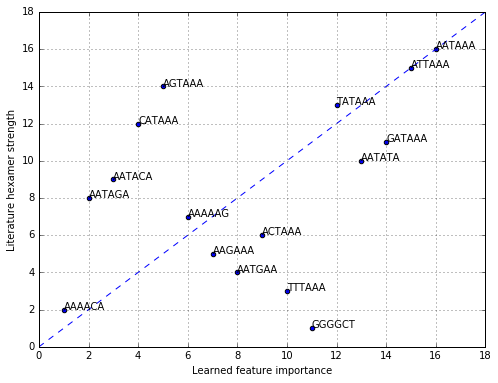

In [40]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
df_strength_merged.plot.scatter(x='learned', y='literature', ax=ax)
for k, row in df_strength_merged.iterrows():
    ax.text(row.learned, row.literature, row.hexamer)

ax.plot([0, 18], [0, 18], '--')
ax.set_xlim([0, 18])
ax.set_ylim([0, 18])

ax.set_xlabel('Learned feature importance')
ax.set_ylabel('Literature hexamer strength')

ax.grid()

# max_depth=6

In [66]:
file = '../../kleat/tree_max_depth_6.pkl'
tree_id = os.path.basename(file)
with open(file, 'rb') as inf:
    clf = pickle.load(inf)

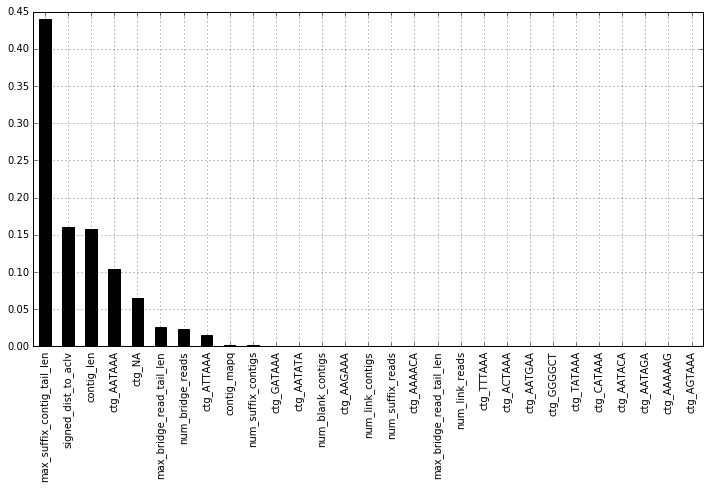

In [67]:
df_fea = pd.Series(clf.feature_importances_, index=KARBOR_FEATURE_COLS)

fig = plt.figure(figsize=(12, 6))
ax = df_fea.sort_values(ascending=False).plot.bar(color='black')
ax.grid()
# ax.set_yscale('log')

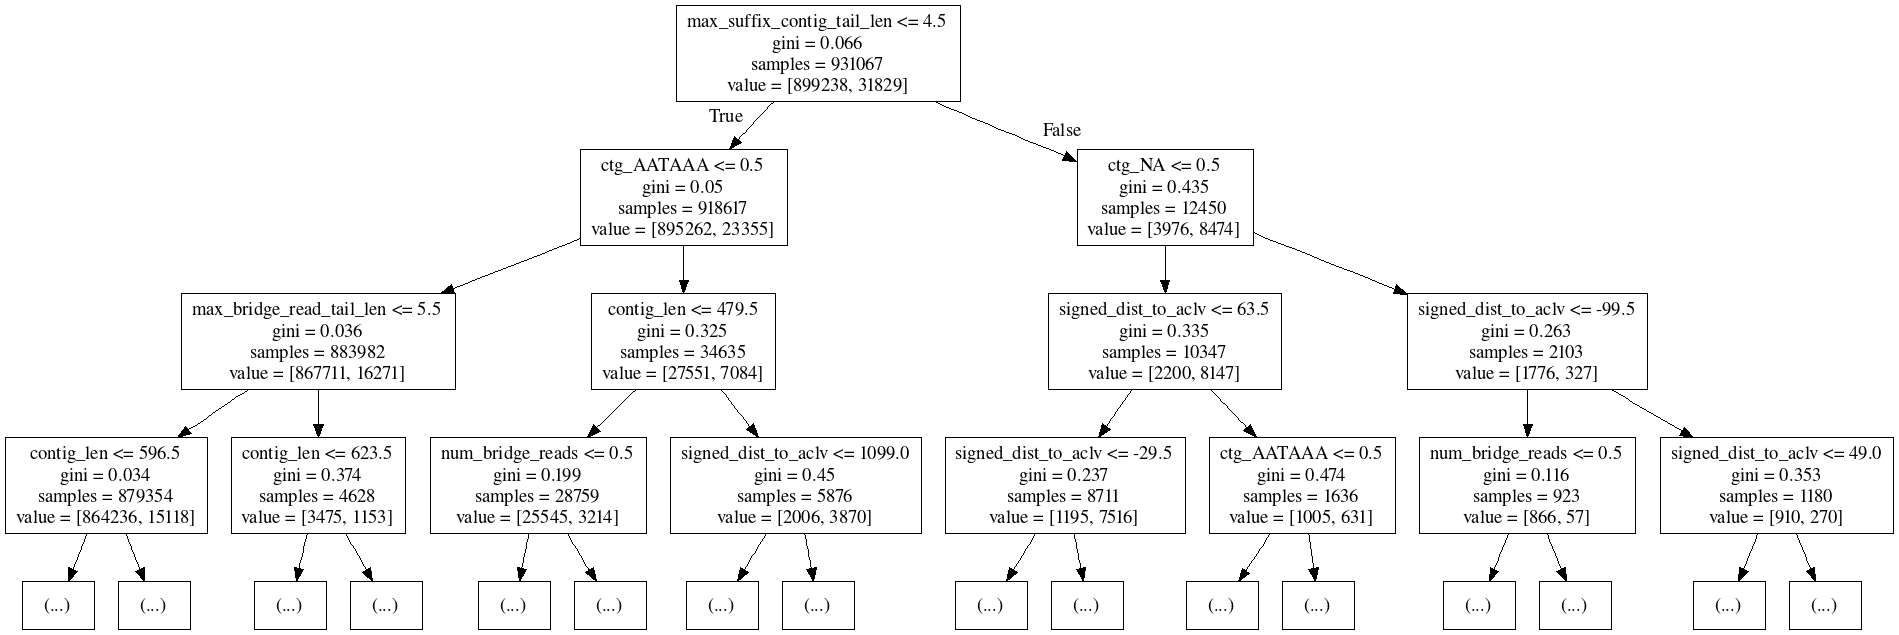

In [68]:
out_dot = f'{tree_id}.dot'
out_png = f'{tree_id}.png'
tree.export_graphviz(clf, max_depth=3, feature_names=KARBOR_FEATURE_COLS, out_file=out_dot)
!dot -Tpng {out_dot} -o {out_png}
Image(out_png)

In [69]:
from kleat.misc.settings import CANDIDATE_HEXAMERS

In [70]:
idx = [_ for _ in df_fea.sort_values(ascending=False).index.values if _.startswith('ctg') and _ != 'ctg_NA']
df_fea.loc[idx]

ctg_AATAAA    0.104157
ctg_ATTAAA    0.015736
ctg_GATAAA    0.000852
ctg_AATATA    0.000349
ctg_AAGAAA    0.000000
ctg_AAAACA    0.000000
ctg_TTTAAA    0.000000
ctg_ACTAAA    0.000000
ctg_AATGAA    0.000000
ctg_GGGGCT    0.000000
ctg_TATAAA    0.000000
ctg_CATAAA    0.000000
ctg_AATACA    0.000000
ctg_AATAGA    0.000000
ctg_AAAAAG    0.000000
ctg_AGTAAA    0.000000
dtype: float64

In [71]:
df_strength = pd.Series(df_fea.loc[idx].index.values).to_frame(name='hexamer')
df_strength['hexamer'] = df_strength['hexamer'].str.replace('ctg_', '')

In [72]:
df_strength['learned'] = df_strength.shape[0] - (df_strength.index.values)

In [73]:
df_strength_literature = pd.DataFrame(CANDIDATE_HEXAMERS, columns=['hexamer', 'literature'])

In [74]:
df_strength_merged = df_strength.merge(df_strength_literature, on='hexamer')

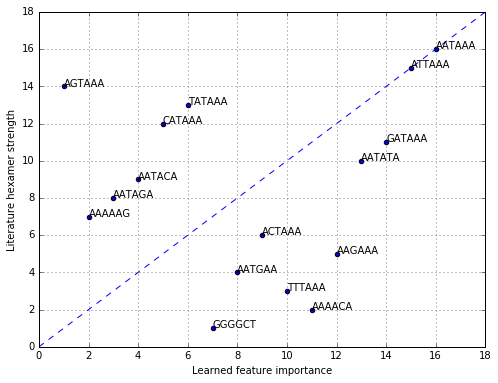

In [75]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
df_strength_merged.plot.scatter(x='learned', y='literature', ax=ax)
for k, row in df_strength_merged.iterrows():
    ax.text(row.learned, row.literature, row.hexamer)

ax.plot([0, 18], [0, 18], '--')
ax.set_xlim([0, 18])
ax.set_ylim([0, 18])

ax.set_xlabel('Learned feature importance')
ax.set_ylabel('Literature hexamer strength')

ax.grid()